<h1 style = "text-align:center"> 机器学习期末大作业</h1>
<h2 style = "text-align:center"> 利用卷积神经网络（CNN）实现交通工具图像识别</h2>

<br>
<div style="font-weight:bold"> 课程信息：机器学习</div>
<br>
<div style="font-weight:bold"> 指导教师：雍宾宾</div>
<br>
<div style="font-weight:bold"> 学生姓名：王润一</div>
<br>
<div style="font-weight:bold"> 校园卡号：320190940491</div>
<br>
<div style="font-weight:bold"> 学生邮箱：wangrunyi19@lzu.edu.cn</div>
<br>
<div style="font-weight:bold"> 项目链接：https://github.com/StudioASX/vehicle-recognition</div>

## 1. 前期准备

In [1]:
# 1.1 准备模块

# 加载Tensorflow 模块
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models

# 加载其他模块
import pathlib
import matplotlib.pyplot as plt
import os,PIL

In [2]:
# 1.2 导入数据

# 找到对应的交通工具（飞机，汽车，轮船）数据库路径
data_dir = "/Users/steven/Documents/vehicle_photos"
data_dir = pathlib.Path(data_dir)

In [3]:
# 1.3 查看数据

# 获取交通工具（飞机，汽车，轮船）数据库信息
# 数据集一共分为airplane，cars，ship四类，分别存放于vehicle_photos文件夹中以各自名字命名的子文件夹中。
# 由结果可知，图片的总数为3000。

image_count = len(list(data_dir.glob('*/*.*')))
print("Total number of images in the dataset: ",image_count)

Total number of images in the dataset:  3000


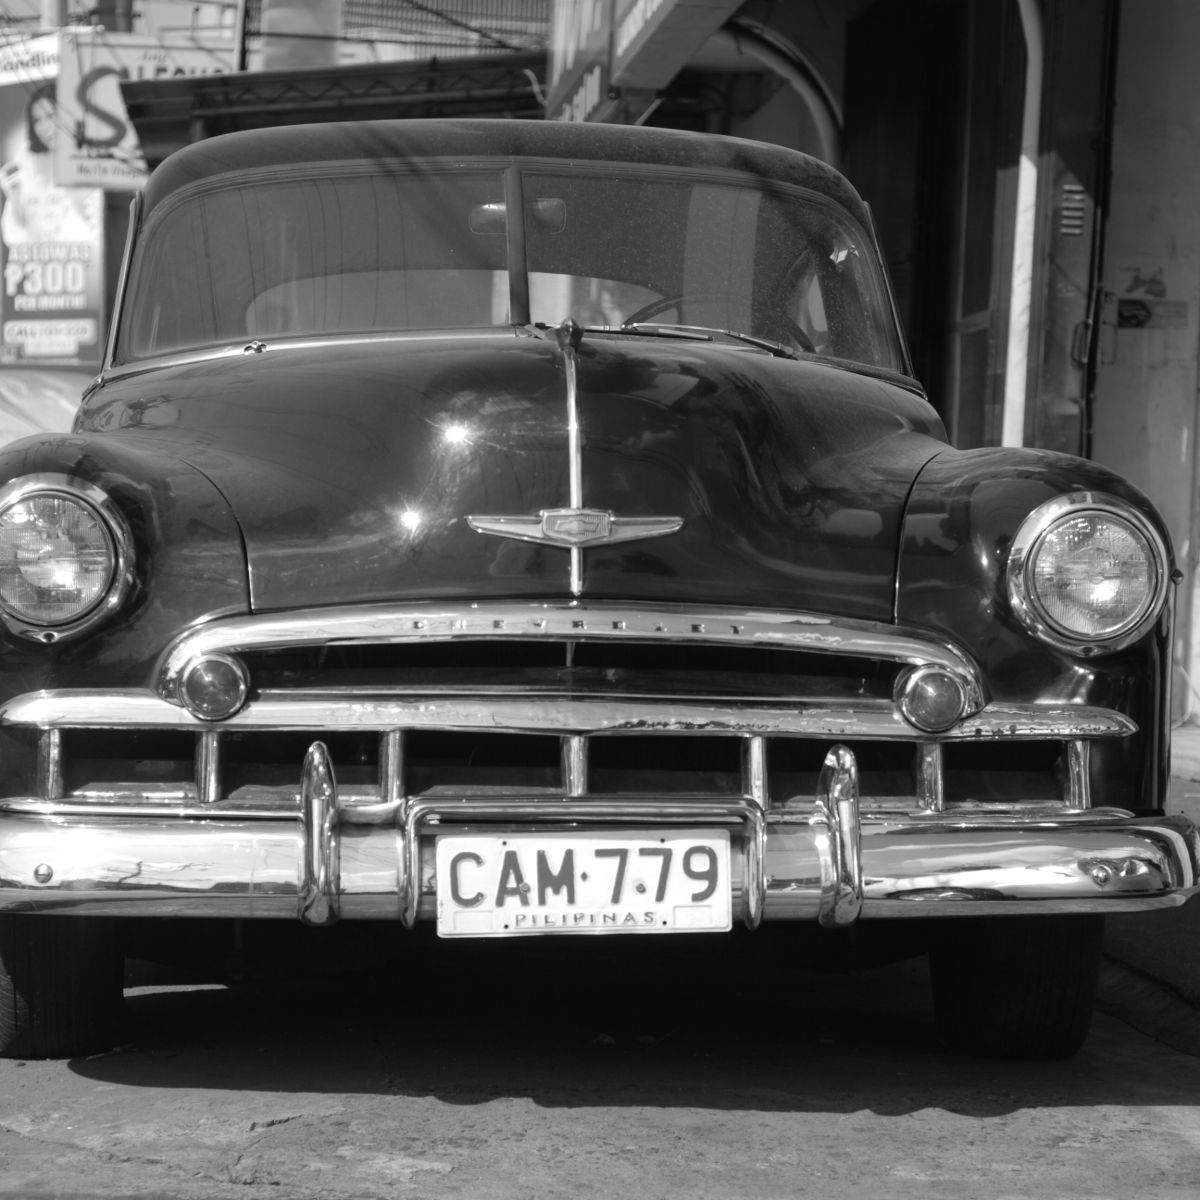

In [4]:
# 从数据库中随机选取一张照片打开看看

roses = list(data_dir.glob('cars/*.*'))
PIL.Image.open(str(roses[10]))

## 2. 数据预处理

In [5]:
# 2.1 加载数据

# 使用image_dataset_from_directory方法将磁盘中的数据加载到tf.data.Dataset中
batch_size = 32
img_height = 180
img_width = 180

# 训练集
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# 验证集
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [6]:
# 我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。
# 从输出的结果我们可以看到，一共有3个交通工具分类，分别为： airplanes，cars，ship 三类

class_names = train_ds.class_names
print(class_names)

['airplanes', 'cars', 'ship']


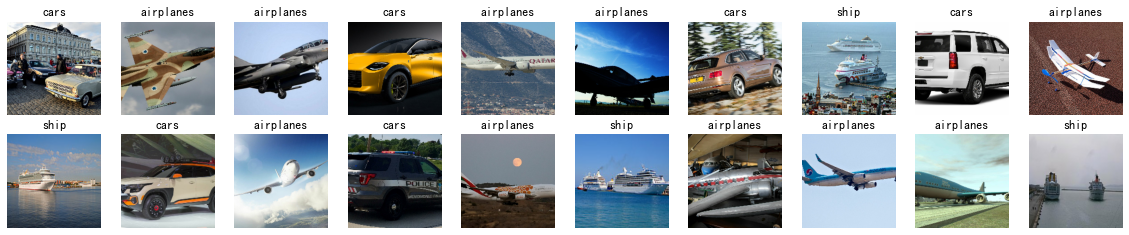

In [7]:
# 2.2 可视化数据

plt.figure(figsize=(20, 10))

for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 10, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

In [8]:
# 2.3 再一次检查数据

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    
# Image_batch是形状的张量（32,180,180,3）。这是一批形状180x180x3的32张图片（最后一维指的是彩色通道RGB）。
# Label_batch是形状（32，）的张量，这些标签对应32张图片

(32, 180, 180, 3)
(32,)


In [9]:
# 2.4 配置数据集

# shuffle()：打乱数据
# prefetch()：预取数据，加速运行
# cache()：将数据集缓存到内存当中，加速运行

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. 构建CNN网络

卷积神经网络（CNN）的输入是张量 (Tensor) 形式的 (image_height, image_width, color_channels)，包含了图像高度、宽度及颜色信息。不需要输入batch size。color_channels 为 (R,G,B) 分别对应 RGB 的三个颜色通道（color channel）。

在此示例中，我们的 CNN 输入，fashion_mnist 数据集中的图片，形状是 (28, 28, 1)即灰度图像。我们需要在声明第一层时将形状赋值给参数input_shape。

In [10]:
num_classes = 4

# layers.Dropout(0.3) 作用是防止过拟合，提高模型的泛化能力。训练准确率与验证准确率相差巨大就是由于模型过拟合导致的

model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 卷积层1，卷积核3*3  
    layers.AveragePooling2D((2, 2)),               # 池化层1，2*2采样
    layers.Conv2D(32, (3, 3), activation='relu'),  # 卷积层2，卷积核3*3
    layers.AveragePooling2D((2, 2)),               # 池化层2，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层3，卷积核3*3
    layers.Dropout(0.3),  
    
    layers.Flatten(),                       # Flatten层，连接卷积层与全连接层
    layers.Dense(128, activation='relu'),   # 全连接层，特征进一步提取
    layers.Dense(num_classes)               # 输出层，输出预期结果
])

model.summary()  # 打印网络结构

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 89, 89, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 43, 43, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

## 4. 训练模型

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

* 损失函数（loss）：用于衡量模型在训练期间的准确率。
* 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
* 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [11]:
# 4.1 模型编译

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# 4.2 训练模型

epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 32s 355ms/step - loss: 0.7795 - accuracy: 0.6750 - val_loss: 0.6062 - val_accuracy: 0.7850
Epoch 2/10
75/75 [==============================] - 26s 340ms/step - loss: 0.4575 - accuracy: 0.8204 - val_loss: 0.5609 - val_accuracy: 0.7933
Epoch 3/10
75/75 [==============================] - 27s 355ms/step - loss: 0.3405 - accuracy: 0.8696 - val_loss: 0.4211 - val_accuracy: 0.8550
Epoch 4/10
75/75 [==============================] - 27s 364ms/step - loss: 0.2314 - accuracy: 0.9154 - val_loss: 0.3722 - val_accuracy: 0.8550
Epoch 5/10
75/75 [==============================] - 30s 406ms/step - loss: 0.1597 - accuracy: 0.9396 - val_loss: 0.3894 - val_accuracy: 0.8683
Epoch 6/10
75/75 [==============================] - 29s 390ms/step - loss: 0.1208 - accuracy: 0.9583 - val_loss: 0.4075 - val_accuracy: 0.8733
Epoch 7/10
75/75 [==============================] - 32s 421ms/step - loss: 0.0517 - accuracy: 0.9846 - val_loss: 0.4555 - val_accuracy: 0.8667

## 5. 模型评估

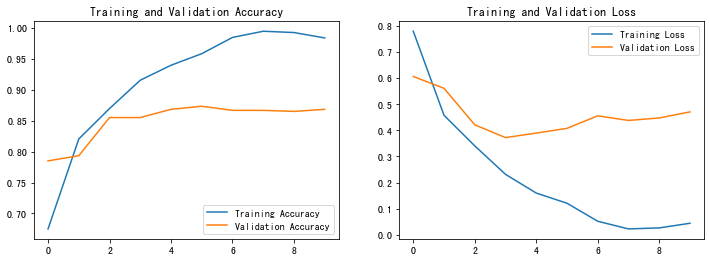

In [13]:
# 模型评估，包括训练集和测试集的准确度（Accuracy）和损失度（Loss）

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()